In [1]:
import pandas as pd
import numpy as np
import os
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

proj_dir = os.path.join(consts['official_indir'], 'Germany')

In [2]:
figure_outdir = 'figures_revision'
Germany_figure_outdir = os.path.join(figure_outdir, 'Germany')

os.makedirs(Germany_figure_outdir, exist_ok=True)

In [3]:
sample_annotations = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=0)

In [4]:

display(sample_annotations['status'].value_counts())

# display(sample_annotations.loc[sample_annotations['in_analysis_dataset'], ['er', 'pr', 'her2', 'ki67']].apply(lambda x:x.value_counts()))

print(f'Total cancers: N = {sample_annotations["in_analysis_dataset"].sum()}')

breast cancer      305
normal              50
normal-adjacent     42
normal-brca1         7
cancer-brca1         3
Name: status, dtype: int64

Total cancers: N = 253


In [5]:
beta_values_Clock_CpGs_revision_pureSamples = pd.read_table(os.path.join(proj_dir, 'beta_values_Clock_CpGs_revision_pureSamples.txt'), index_col=0)
assert (beta_values_Clock_CpGs_revision_pureSamples.isna().mean(axis=0) < 0.05).all()

### Perform IHC subtyping

In [6]:
marker_state_dict = {0:'Negative', 1:'Positive'}
for col in ['er', 'pr', 'her2']:
    sample_annotations[col] = sample_annotations[col].map(marker_state_dict)

sample_annotations['HR+'] = (sample_annotations['er'] == 'Positive') | (sample_annotations['pr'] == 'Positive')
sample_annotations['HR-'] = (sample_annotations['er'] == 'Negative') & (sample_annotations['pr'] == 'Negative')

sample_annotations['LumA_type'] = sample_annotations['HR+'] & (sample_annotations['her2'] == 'Negative')
sample_annotations['LumB_type'] = sample_annotations['HR+'] & (sample_annotations['her2'] == 'Positive')
sample_annotations['Her2_type'] = (sample_annotations['her2'] == 'Positive') & sample_annotations['HR-']
sample_annotations['Triple-Negative_type'] = sample_annotations['HR-'] & (sample_annotations['her2'] == 'Negative')

subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Triple-Negative_type']

for subtype in subtype_list:
    sample_annotations[subtype] = sample_annotations[subtype].map({True:subtype.split('_type')[0], False:''})

sample_annotations['subtype.ihc'] = sample_annotations[subtype_list].apply(lambda row:''.join(row), axis=1)
sample_annotations.loc[sample_annotations['subtype.ihc'] == '', 'subtype.ihc'] = None

### NA Values

In [7]:
sample_annotations.loc[sample_annotations['in_analysis_dataset'], ['er', 'pr', 'HR+', 'her2']].isna().sum(axis=0)

er       2
pr       6
HR+      0
her2    34
dtype: int64

In [8]:
(sample_annotations['in_analysis_dataset'] & sample_annotations['er'].isna() & sample_annotations['pr'].isna()).sum()

2

In [9]:
(sample_annotations['in_analysis_dataset'] & ~sample_annotations['HR+'] & ~sample_annotations['HR-']).sum()

3

## Make Figures

In [10]:
## Configure graph
sf = consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')
sf = 0.4

In [11]:
sample_annotations.name = 'Germany'

In [12]:
sample_annotations['Ki-67'] = sample_annotations['ki67'].map({0:'Ki-67 Negative', 1:'Ki-67 Positive'})

In [ ]:
epi_util.saveBoxPlotNew(sample_annotations, 'Ki-67', restrict=True,
                        var_y='c_beta',
                        outdir=Germany_figure_outdir, title=True,
                        palette=consts['palette_jco'], plot_ymax_mult=0.33,
                        figsize=figsize * [1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

print('Wilcoxon p-value')
epi_util.getWilcoxonPvalueTable(sample_annotations.loc[sample_annotations['in_analysis_dataset']],
                                'Ki-67', 'c_beta').dropna(how='all', axis=0).dropna(how='all', axis=1).fillna('')


Medians:


subtype.ihc
Her2               0.873534
LumA               0.847870
LumB               0.850387
Triple-Negative    0.832924
Name: c_beta, dtype: float64

Wilcoxon p-values:


,LumB,Her2,Triple-Negative
LumA,0.5215,0.025776,0.076515
LumB,,0.019598,0.051773
Her2,,,0.006910


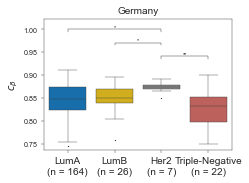

In [12]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='subtype.ihc', xlabel='',
                        outdir=Germany_figure_outdir, title=True,
                        use_groups = ['LumA', 'LumB', 'Her2', 'Triple-Negative'],
                        palette=consts['palette_jco'],
                        figsize=figsize * [1.2, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

print('Medians:')
display(sample_annotations.loc[sample_annotations['in_analysis_dataset']].groupby('subtype.ihc')['c_beta'].median())

print('Wilcoxon p-values:')
display(epi_util.getWilcoxonPvalueTable(sample_annotations.loc[sample_annotations['in_analysis_dataset']],
                                'subtype.ihc', 'c_beta', use_groups=['LumA', 'LumB', 'Her2', 'Triple-Negative']).dropna(how='all', axis=0).dropna(how='all', axis=1).fillna(''))

<Axes: ylabel='LUMP Purity'>

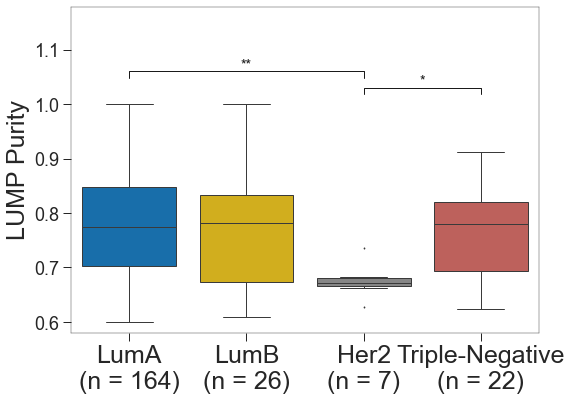

In [45]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='LUMP', restrict=True,
                        var_cat='subtype.ihc', xlabel='',
                        outfile=False, title=False, ylabel='LUMP Purity',
                        use_groups = ['LumA', 'LumB', 'Her2', 'Triple-Negative'],
                        palette=consts['palette_jco'],
                        figsize=figsize * [1.2, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=1, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

<Axes: xlabel='HR+', ylabel='$c_β$'>

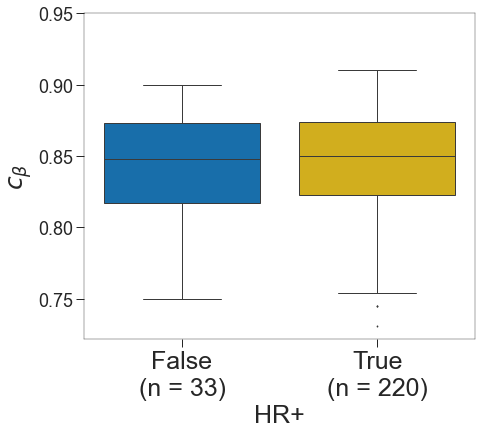

In [46]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='HR+', xlabel='HR+',
                        outfile=False, title=False, ylabel='HR Status',
                        palette=consts['palette_jco'],
                        figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=1, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

<Axes: xlabel='Her2 Positive', ylabel='$c_β$'>

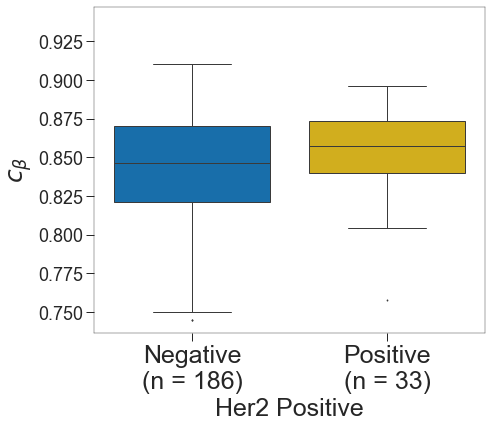

In [47]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='her2', xlabel='Her2 Positive',
                        outfile=False, title=False,
                        palette=consts['palette_jco'],
                        figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=1, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

### Save figure data

In [15]:
SuppFigS2_df = sample_annotations[['c_beta', 'subtype.ihc', 'Ki-67']].copy()
SuppFigS2_df.reset_index(names='ID', inplace=True)

epi_util.saveFigureData(SuppFigS2_df, 'Supp_Figure_S2')